In [1]:
import warnings; warnings.simplefilter('ignore')

import os
import time
import torch
import itertools
import torch.nn as nn
from cell import graph_utils, utils, plot_utils
from cell.Word2vec import prepare_vocab, dataloader, wv
from stellargraph import StellarGraph
from torch.nn import functional as F
from stellargraph.data import BiasedRandomWalk
import cell.BiasedDirectedWeightedWalk as BDWW
from stellargraph import StellarDiGraph
import seaborn as sns
from IPython.display import Image
from cell import coupled_wv as cp


In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Create an undirected graph

In [3]:
edges = pd.DataFrame([[1, 3, 1],
                     [1, 4, 1],
                     [2, 3, 1],
                     [3, 4, 1],
                     [4, 5, 1],
                     [2, 6, 1],
                     [6, 7, 1],
                     [3, 7, 1],
                     [4, 7, 1],
                     [7, 8, 1],
                     [5, 8, 1],
                     [6, 9, 1],
                     [9, 10, 1], 
                     [10, 11, 1], 
                     [7, 10, 1], 
                     [8, 11, 1]], columns=['source', 'target', 'weight'])

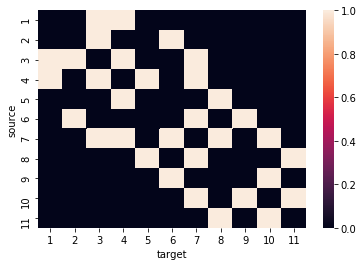

In [4]:
weight_mat = graph_utils.return_weight_mat_from_edgelist(edges, directed=False)
sns.heatmap(weight_mat)

In [5]:
# 1) for each layer first create a nx-Digraph
nxg = graph_utils.build_nx_graph(source_target_weight=edges, directed=False)

# 2) Create stellar Di graphs
sg = StellarGraph(nxg)

# 3) Initialize the walk and do the begin checks
rw = BiasedRandomWalk(sg)

nodes = sg.nodes()
walks = rw.run(nodes=nodes,
               length=10000,
               n=1۰,
               p=1,
               q=1,
               weighted=True)

In [11]:
dataloader, index_2_word, word_2_index, vocab = cp.return_mcbow_dataloader(walks)

lenght of vocabulary: 11
a node called pad is added for padding and its index is zero
a node called pad is added for padding and its index is zero
MCBOW by default adds a padding node called pad with index zero
There are 1100000 pairs of target and context words


In [17]:
model, loss = cp.run(vocab, embedding_size=2, learning_rate=0.001, n_epochs=10, data_loader=dataloader, device=device)

the index2word and word2index dicts must have padding with index zero
epoch: 1/10, loss:2.3845
epoch: 10/10, loss:1.6603


Reading cldf from: //Users/fahimehb/Documents/NPP_GNN_project/dat/cl_df_VISp_annotation.csv


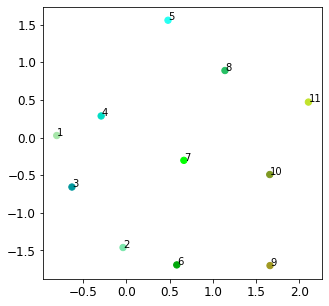

In [18]:
from cell import analysis, plot_utils
cldf = utils.read_visp_npp_cldf()
vectors = model.embeddings.weight.detach().numpy()
vectors = pd.DataFrame(vectors, columns=["Z0", "Z1"], index=index_2_word.values())
vectors.index.name = "cluster_id"
vectors.index = vectors.index.astype('str')
vectors = vectors.merge(cldf, on='cluster_id')

fig = plot_utils.plot_embedding(vectors, plot_dim=2, plot_size=(5,5), annotation=True)

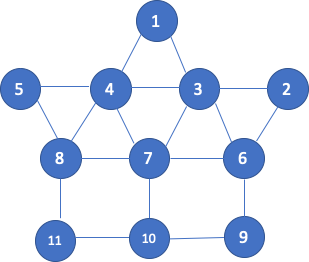

In [17]:
Image("/Users/fahimehb/Documents/NPP_GNN_project/code/footbal_4_3_3.png")

The embedding we found makes a lot of sense as the real graph is shown in the figure.

Now we must be able to generate the same thing with the coupled word2vec in both arms if they are not coupled.

In [37]:
arm_keys, data_loader, index_2_word, word_2_index, vocabulary = cp.return_dataloader_coupled(walks, 11)

lenght of vocabulary: 11
There are 1099780 pairs of receiver target and context words
There are 1099890 pairs of emitter target and context words


In [39]:
for i, (data1, data2) in enumerate(data_loader):
    print(data1)
    break

[tensor([3, 2, 1,  ..., 9, 8, 5]), tensor([ 0,  3,  2,  ..., 10,  9,  8])]


In [40]:
print(data1[0][0:10], data1[1][0:10])

tensor([3, 2, 1, 2, 0, 3, 6, 5, 8, 5]) tensor([0, 3, 2, 1, 2, 0, 3, 6, 5, 8])


In [41]:
print(data2[0][0:10], data2[1][0:10])

tensor([3, 2, 1, 2, 0, 3, 6, 5, 8, 5]) tensor([0, 3, 2, 1, 2, 0, 3, 6, 5, 8])


In [42]:
walks[0][0:20]

[1, 4, 3, 2, 3, 1, 4, 7, 6, 9, 6, 2, 6, 2, 3, 4, 1, 3, 1, 3]

In [43]:
[word_2_index[i] for i in walks[0][0:20]]

[0, 3, 2, 1, 2, 0, 3, 6, 5, 8, 5, 1, 5, 1, 2, 3, 0, 2, 0, 2]

### Coupled model with two independent arms but only one loss

In [ ]:
model_cop_v2, training_loss_cop_v2 = cp.run_coupled(data_loader=data_loader, 
                                              vocab_size= 11, 
                                              embedding_size=2, 
                                              learning_rate=0.001, 
                                              n_epochs=50, 
                                              n_arm=2, 
                                              batch_size=2000, 
                                              arm_keys=arm_keys,
                                              device=device)

epoch: 1/50, loss:4.5310
epoch: 10/50, loss:2.4210


### uncoupled word2vec with 400 epochs and different emitter, reciver dataset produced from the same walk

Reading cldf from: //Users/fahimehb/Documents/NPP_GNN_project/dat/cl_df_VISp_annotation.csv


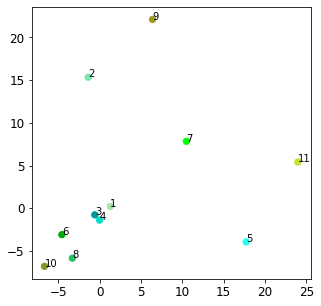

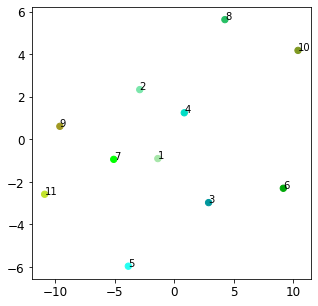

In [9]:
from cell import analysis, plot_utils
cldf = utils.read_visp_npp_cldf()
vectors = model_cop.embeddings[0].weight.detach().numpy()
vectors = pd.DataFrame(vectors, columns=["Z0", "Z1"], index=index_2_word.values())
vectors.index.name = "cluster_id"
vectors.index = vectors.index.astype('str')
vectors = vectors.merge(cldf, on='cluster_id')

fig = plot_utils.plot_embedding(vectors, plot_dim=2, plot_size=(5,5), annotation=True)

vectors = model_cop.embeddings[1].weight.detach().numpy()
vectors = pd.DataFrame(vectors, columns=["Z0", "Z1"], index=index_2_word.values())
vectors.index.name = "cluster_id"
vectors.index = vectors.index.astype('str')
vectors = vectors.merge(cldf, on='cluster_id')

fig = plot_utils.plot_embedding(vectors, plot_dim=2, plot_size=(5,5), annotation=True)

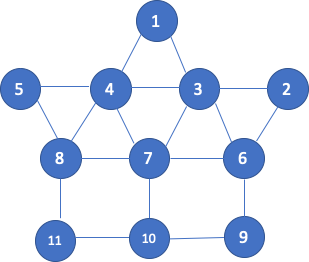

In [10]:
Image("/Users/fahimehb/Documents/NPP_GNN_project/code/footbal_4_3_3.png")

### GAN like word2vec

In [27]:
class EmitterReceiver(nn.Module):
    def __init__(self, embedding_size, vocab_size):
        super(EmitterReceiver, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_size)
        self.linear = nn.Linear(embedding_size, vocab_size)

    def encoder(self, context_word):
        h1 = self.embeddings(context_word)
        node_embeddings = [self.embeddings(torch.tensor(i)) for i
                           in range(self.vocab_size)]
        return node_embeddings, h1

    def decoder(self, context_word_embedding):
        h2 = self.linear(context_word_embedding)
        return h2

    def forward(self, context_word):
        emb = [None] 
        predictions = [None] 
        context_word_embedding = [None] 

        node_embeddings, word_embedding = self.encoder(context_word)
        emb = node_embeddings
        context_word_embedding = word_embedding
        predictions = self.decoder(context_word_embedding)

        return emb, predictions

In [32]:
Emitter = EmitterReceiver(vocab_size=11, embedding_size=2)
Receiver = EmitterReceiver(vocab_size=11, embedding_size=2)

Emitter_optimizer = torch.optim.Adam(Emitter.parameters(), lr=0.001)
Receiver_optimizer = torch.optim.Adam(Receiver.parameters(), lr=0.001)

loss = nn.CrossEntropyLoss()
Emitter.to(device)
Receiver.to(device)

training_loss = []

for epoch in range(n_epochs):
    t0 = time.time()
    losses = []
    for i, (target, context) in enumerate(data_loader):
        target = target.to(device)
        context = context.to(device)
        
        Emitter_emb, Emitter_prediction = Emitter(context)
        Emitter_emb, Emitter_prediction = Emitter(context)
        
        generator_loss = loss(generator_discriminator_out, true_labels)
        generator_loss.backward()
        generator_optimizer.step()
        
        
        prediction = model(context)
        loss = criterion(prediction, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    t1 = time.time()

    training_loss.append(np.mean(losses))
    if epoch % 9 == 0:
        print(f'epoch: {epoch + 1}/{n_epochs}, loss:{np.mean(losses):.4f}')

EmitterReceiver(
  (embeddings): Embedding(11, 2)
  (linear): Linear(in_features=2, out_features=11, bias=True)
)

In [ ]:
        noise = torch.randint(0, 2, size=(batch_size, input_length)).float()
        generated_data = generator(noise)

        # Generate examples of even real data
        true_labels, true_data = generate_even_data(max_int, batch_size=batch_size)
        true_labels = torch.tensor(true_labels).float()
        true_data = torch.tensor(true_data).float()

        # Train the generator
        # We invert the labels here and don't train the discriminator because we want the generator
        # to make things the discriminator classifies as true.
        generator_discriminator_out = discriminator(generated_data)
        generator_loss = loss(generator_discriminator_out, true_labels)
        generator_loss.backward()
        generator_optimizer.step()

        # Train the discriminator on the true/generated data
        discriminator_optimizer.zero_grad()
        true_discriminator_out = discriminator(true_data)
        true_discriminator_loss = loss(true_discriminator_out, true_labels)

        # add .detach() here think about this
        generator_discriminator_out = discriminator(generated_data.detach())
        generator_discriminator_loss = loss(generator_discriminator_out, torch.zeros(batch_size))
        discriminator_loss = (true_discriminator_loss + generator_discriminator_loss) / 2
        discriminator_loss.backward()
        discriminator_optimizer.step()

In [33]:
model.

MCBOW_Word2Vec(
  (embeddings): Embedding(12, 2, padding_idx=0)
  (batch_norm): BatchNorm1d(2, eps=1e-10, momentum=0.1, affine=False, track_running_stats=True)
  (linear): Linear(in_features=2, out_features=12, bias=True)
)

# Directed graph 

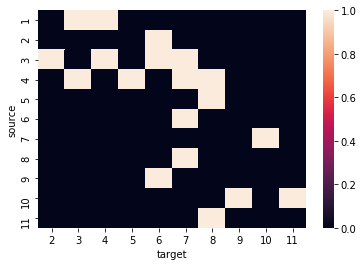

In [6]:
edges = pd.DataFrame([[1, 4, 1],
                      [1, 3, 1], 
                      [4, 3, 1], 
                      [4, 5, 1], 
                      [4, 8, 1], 
                      [4, 7, 1],
                      [3, 4, 1],
                      [3, 7, 1],
                      [3, 6, 1],
                      [3, 2, 1],
                      [2, 6, 1], 
                      [5, 8, 1], 
                      [6, 7, 1], 
                      [7, 10, 1], 
                      [8, 7, 1], 
                      [9, 6, 1], 
                      [10, 9, 1], 
                      [10, 11, 1], 
                      [11, 8, 1]], columns=['source', 'target', 'weight'])

weight_mat = graph_utils.return_weight_mat_from_edgelist(edges, directed=True)
sns.heatmap(weight_mat)

In [7]:
# 1) for each layer first create a nx-Digraph
nxg = graph_utils.build_nx_graph(source_target_weight=edges, directed=True)

# 2) Create stellar Di graphs
sdg = StellarDiGraph(nxg)

BDWW.BeginWalk(sdg, begin_checks=True, weighted=True, directed=True)

rw = BDWW.BiasedDirectedRandomWalk(sdg,
                                   directed=True,
                                   weighted=True,
                                   begin_checks=False)

nodes = list(sdg.nodes())
walks = rw.run(nodes=nodes,
               length=10000,
               n=1,
               p=1,
               q=1,
               weighted=True,
               directed=True)

Checking all the weights on all the edges!
Computing the node importance!


In [8]:
vocabulary = prepare_vocab.get_vocabulary(walks)

print(f'lenght of vocabulary: {len(vocabulary)}')

word_2_index = prepare_vocab.get_word2idx(vocabulary, padding=True)
index_2_word = prepare_vocab.get_idx2word(vocabulary, padding=True)

lenght of vocabulary: 11
a node called pad is added for padding and its index is zero
a node called pad is added for padding and its index is zero


In [8]:
context_tuple_list = prepare_vocab.MCBOW_get_word_context_tuples(walks, window=2)

MCBOW by default adds a padding node called pad with index zero
There are 110000 pairs of target and context words


In [9]:
dataset = dataloader.MCBOW_WalkDataset(context_tuple_list, word_2_index)

data_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                          batch_size=2000, 
                                          shuffle=True,
                                          num_workers=0)

In [11]:
model, loss = run(vocabulary, embedding_size=2, learning_rate=0.0001, n_epochs=20, data_loader=data_loader)

the index2word and word2index dicts must have padding with index zero
epoch: 1/20, loss:3.0616
epoch: 2/20, loss:3.0404
epoch: 3/20, loss:3.0193
epoch: 4/20, loss:2.9985
epoch: 5/20, loss:2.9777
epoch: 6/20, loss:2.9571
epoch: 7/20, loss:2.9369
epoch: 8/20, loss:2.9167
epoch: 9/20, loss:2.8967
epoch: 10/20, loss:2.8769
epoch: 11/20, loss:2.8574
epoch: 12/20, loss:2.8378
epoch: 13/20, loss:2.8186
epoch: 14/20, loss:2.7994
epoch: 15/20, loss:2.7804
epoch: 16/20, loss:2.7615
epoch: 17/20, loss:2.7427
epoch: 18/20, loss:2.7239
epoch: 19/20, loss:2.7054
epoch: 20/20, loss:2.6869


Reading cldf from: //Users/fahimehb/Documents/NPP_GNN_project/dat/cl_df_VISp_annotation.csv


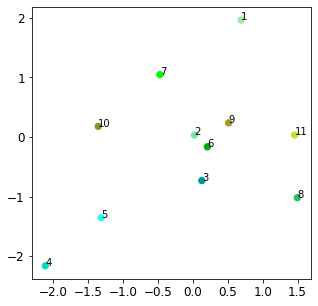

In [12]:
from cell import analysis, plot_utils
cldf = utils.read_visp_npp_cldf()
vectors = model.embeddings.weight.detach().numpy()
vectors = pd.DataFrame(vectors, columns=["Z0", "Z1"], index=index_2_word.values())
vectors.index.name = "cluster_id"
vectors.index = vectors.index.astype('str')
vectors = vectors.merge(cldf, on='cluster_id')

fig = plot_utils.plot_embedding(vectors, plot_dim=2, plot_size=(5,5), annotation=True)

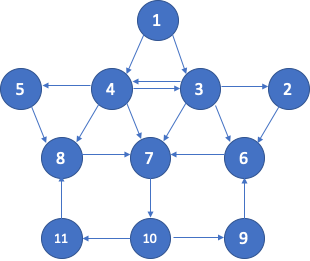

In [27]:
Image("/Users/fahimehb/Documents/NPP_GNN_project/code/directed_footbal_4_3_3.png")

As it is clear, in order to find communities, it is not possible to use the traditional word2vec model.

### Coupled word2vec

Reading cldf from: //Users/fahimehb/Documents/NPP_GNN_project/dat/cl_df_VISp_annotation.csv


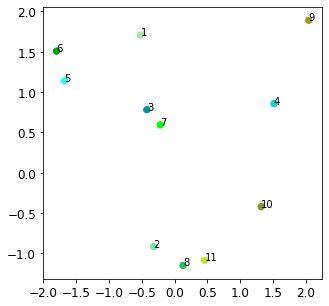

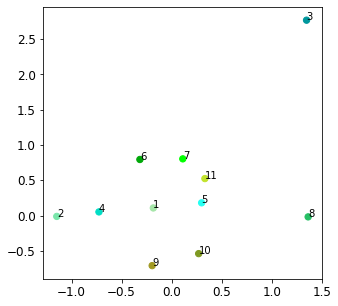

In [34]:
from cell import analysis, plot_utils
cldf = utils.read_visp_npp_cldf()
vectors = model.embeddings[0].weight.detach().numpy()
vectors = pd.DataFrame(vectors, columns=["Z0", "Z1"], index=index_2_word.values())
vectors.index.name = "cluster_id"
vectors.index = vectors.index.astype('str')
vectors = vectors.merge(cldf, on='cluster_id')
fig = plot_utils.plot_embedding(vectors, plot_dim=2, plot_size=(5,5), annotation=True)


vectors = model.embeddings[1].weight.detach().numpy()
vectors = pd.DataFrame(vectors, columns=["Z0", "Z1"], index=index_2_word.values())
vectors.index.name = "cluster_id"
vectors.index = vectors.index.astype('str')
vectors = vectors.merge(cldf, on='cluster_id')

fig = plot_utils.plot_embedding(vectors, plot_dim=2, plot_size=(5,5), annotation=True)

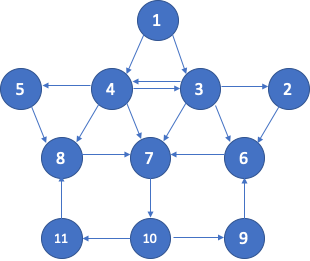

In [21]:
Image("/Users/fahimehb/Documents/NPP_GNN_project/code/directed_footbal_4_3_3.png")